# Imports

In [40]:
import datetime
import os
import sys
from dataclasses import dataclass
import sklearn
from sklearn import model_selection
import matplotlib
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import statsmodels.api as sm

# Set the current working directory and get paths of load profiles

In [41]:

cwd = os.getcwd()

In [42]:
def get_directories(path) -> list:
    """
    Returns a list of directories in the given path.
    """
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
directories = get_directories('Profiles')
directories.sort()

# Builds load profile dataframe using all Excel Files

In [84]:
def load_profile_df(filename) -> pd.DataFrame:
    """
    Converts xls and xlsx files to pandas dataframe.
    """
    print(filename)
    f = cwd+'/Profiles/'+filename+'/'+os.listdir(cwd+'/Profiles/'+filename)[0]
    print(f)
    if f.endswith('.xls') or f.endswith('.xlsx'):
        df = pd.read_excel(f, sheet_name=None)
        df = pd.concat(df)
        #print(df)
        df.drop("ADDTIME", axis=1, inplace=True)
        df.rename(columns={"PType_WZ":"Station"}, inplace=True)
        df.drop((df.columns)[-4:], axis=1, inplace=True)
        original_columns = list(df.columns)
        #print(original_columns)
        original_columns[0] = "Station"
        original_columns = ["Load at Interval {}".format(i) for i in range(1, len(original_columns[:])-1)]
        interval_column_labels = original_columns
        original_columns.insert(0, "Station")
        original_columns.insert(1, "Date")
        #df['Load Intervals'] = df[interval_column_labels].shift(len(interval_column_labels)-1, axis = "columns")
        #df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
        #print(original_columns)
        df.columns = original_columns
        #print(df.columns)
        #df.groupby(df.index.day).mean()
        #df.set_index('Date', inplace=True)
        #df.set_index(interval_column_labels, inplace=True)
        #print(df.head())
    else:
        print('File type not supported. ', f)
        sys.exit()
    return df, interval_column_labels
def concat_all_excel_dfs(directories):
    full_df = pd.DataFrame()
    for d in directories:
        df, _ = load_profile_df(d)
        full_df = pd.concat([full_df, df], ignore_index = True)
    return full_df
my_load_profiles = concat_all_excel_dfs(directories)


ERCOT_Backcasted_Load_Profiles_2016
/home/austin/Desktop/Repositories/dae/Profiles/ERCOT_Backcasted_Load_Profiles_2016/ERCOT Backcasted Load Profiles 2016.xls
ERCOT_Backcasted_Load_Profiles_2017
/home/austin/Desktop/Repositories/dae/Profiles/ERCOT_Backcasted_Load_Profiles_2017/ERCOT Backcasted Load Profiles 2017.xlsx


/home/austin/Desktop/Repositories/dae/LFvenv/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


ERCOT_Backcasted_Load_Profiles_2018
/home/austin/Desktop/Repositories/dae/Profiles/ERCOT_Backcasted_Load_Profiles_2018/ERCOT Backcasted Load Profiles 2018.xlsx
ERCOT_Backcasted_Load_Profiles_2019
/home/austin/Desktop/Repositories/dae/Profiles/ERCOT_Backcasted_Load_Profiles_2019/ERCOT Backcasted Load Profiles 2019.xlsx
ERCOT_Backcasted_Load_Profiles_2020
/home/austin/Desktop/Repositories/dae/Profiles/ERCOT_Backcasted_Load_Profiles_2020/ERCOT Backcasted Load Profiles 2020.xlsx
ERCOT_Backcasted_Load_Profiles_2021
/home/austin/Desktop/Repositories/dae/Profiles/ERCOT_Backcasted_Load_Profiles_2021/ERCOT Backcasted Load Profiles 2021.xlsx


In [85]:
my_load_profiles2 = my_load_profiles.copy()
my_load_profiles2.index = pd.to_datetime(my_load_profiles2['Date'], unit = 's')
print(my_load_profiles2.head())

                  Station       Date  Load at Interval 1  Load at Interval 2  \
Date                                                                           
2016-01-01  BUSHIDG_COAST 2016-01-01              11.489              11.413   
2016-01-02  BUSHIDG_COAST 2016-01-02              11.668              11.589   
2016-01-03  BUSHIDG_COAST 2016-01-03              11.457              11.381   
2016-01-04  BUSHIDG_COAST 2016-01-04              11.358              11.280   
2016-01-05  BUSHIDG_COAST 2016-01-05              11.492              11.418   

            Load at Interval 3  Load at Interval 4  Load at Interval 5  \
Date                                                                     
2016-01-01              11.364              11.325              11.312   
2016-01-02              11.538              11.494              11.472   
2016-01-03              11.332              11.291              11.271   
2016-01-04              11.228              11.182              11.16

In [113]:
my_load_profiles = my_load_profiles2.copy()

# Plots a single day and also prints first 5 rows, shape, columns, and index of the load profile dataframe

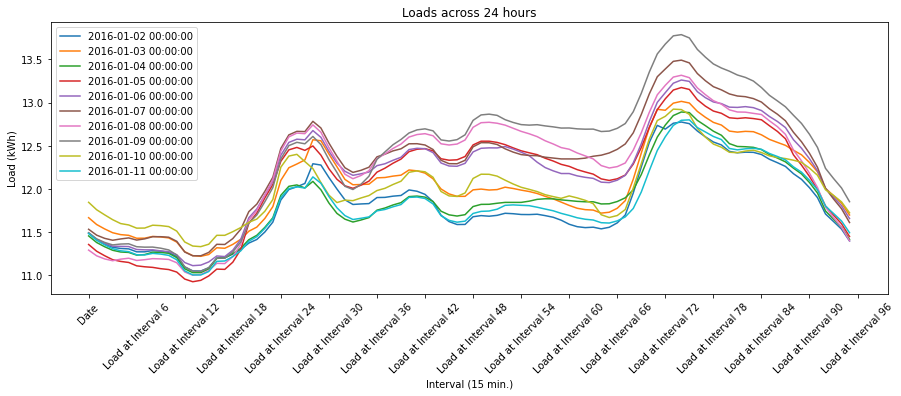

In [124]:
'''Plot/Evaluate Data'''
def plot_load_data(df):
    """
    Plot the load data for each row in the dataframe."""
    #df.drop(df.columns[:2], axis=1, inplace=True)
    #print(df.head())
    plt.figure(figsize=(15,5))
    if "Station" in df.columns:
        df.drop("Station", axis=1, inplace=True)
    #df = df.astype(int)
    for i in range(10):
        plt.plot(df.iloc[i,1:])
    plt.title("Loads across 24 hours")
    plt.xticks(np.arange(0, len(df.columns), 6), df.columns[::6], rotation=45)
    plt.xlabel("Interval (15 min.)")
    plt.ylabel("Load (kWh)")
    plt.legend(df["Date"].iloc[1:11])
    plt.show()
    #df.plot()
#print("MY LOAD DATAFRAME: ")
#print(my_load_profiles)
#print(my_load_profiles.shape)
#print(my_load_profiles.columns)
#print(my_load_profiles.index)
plot_load_data(my_load_profiles2)


# Check seasonality and trends of the load profile dataframe

In [ ]:
my_load_profiles['Date'] = pd.to_datetime(my_load_profiles['Date'], format='%m/%d/%Y')
decomp = sm.tsa.seasonal_decompose(my_load_profiles, model='additive', period=94)
fig = decomp.plot()
matplotlib.rcParams['figure.figsize'] = (15, 5)

KeyError: 'Date'

# Moving Average Model to be used as baseline

<AxesSubplot:title={'center':'Moving Average'}>

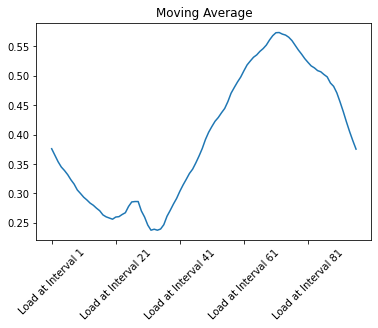

In [ ]:
def moving_average(df, window):
    """
    Calculates the moving average of a given dataframe.
    """
    return df.rolling(window=window).mean()
lp_df = my_load_profiles.copy()
#lp_df = lp_df.T
ma_df = moving_average(lp_df, window=3)

def build_moving_average(df, window):
    """ Build a moving average model."""

#ma_df = ma_df.T
#print(ma_df)
#lp_df['Moving_Avg'] = ma_df
#print(ma_df)
ma_df.iloc[-1].plot(rot=45, title='Moving Average')

# Training, Validation Split

In [ ]:

train_df = my_load_profiles[:int(len(my_load_profiles) * 0.9)]
val_df = my_load_profiles[int(len(my_load_profiles) * 0.9):]
train_df.fillna(0, inplace = True)
val_df.fillna(0, inplace = True)
#print(train_df.isnull().any())
#print(val_df.isnull().any())

def moving_average(df, window):
    """
    Calculates the moving average of a given dataframe.
    """
    return df.rolling(window=window).mean()
vdf = val_df.copy()
#lp_df = lp_df.T
vdma_df = moving_average(vdf, window=3)
#ma_df = ma_df.T
#print(ma_df)
#lp_df['Moving_Avg'] = ma_df



/home/austin/Desktop/Repositories/dae/LFvenv/lib/python3.8/site-packages/pandas/core/frame.py:5171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


# Define and train Neural Network Model

In [ ]:
nn = tf.keras.Sequential([
    tf.keras.layers.Dense(96, input_shape=(96,), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(96, activation='relu'),
])
nn.compile(optimizer='adam', loss='mean_absolute_error')
target_df = train_df.shift(1, axis = 0)
target_df.fillna(0, inplace=True)
#print(target_df)
nn.fit(train_df, target_df, epochs=10)
nn_predictions = nn.predict(val_df)
#nn_predictions = pd.DataFrame(nn_predictions)
#print(nn_predictions)


print(nn.summary())

2021-08-23 19:59:36.971785: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-23 19:59:37.018596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-23 19:59:37.019025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.74GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-23 19:59:37.019086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-23 19:59:37.019131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library '

Epoch 1/10
14013/14013 [==============================] - 8s 557us/step - loss: 5.6052
Epoch 2/10
14013/14013 [==============================] - 8s 559us/step - loss: 5.1639
Epoch 3/10
14013/14013 [==============================] - 8s 560us/step - loss: 5.1189
Epoch 4/10
14013/14013 [==============================] - 8s 558us/step - loss: 5.0850
Epoch 5/10
14013/14013 [==============================] - 8s 558us/step - loss: 5.0693
Epoch 6/10
14013/14013 [==============================] - 8s 560us/step - loss: 5.0270
Epoch 7/10
14013/14013 [==============================] - 8s 556us/step - loss: 5.0261
Epoch 8/10
14013/14013 [==============================] - 8s 559us/step - loss: 4.9569
Epoch 9/10
14013/14013 [==============================] - 8s 558us/step - loss: 4.9608
Epoch 10/10
14013/14013 [==============================] - 8s 558us/step - loss: 4.9712
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape  

# Akaike Information Criterion (AIC), out-of-sample error estimate, lower AIC values indicate higher fidelity for out of sample predictions by moving average.
# - Neural Network and Moving Average Baseline

In [ ]:
#print(nn_predictions)
#print(val_df)
nn_predictions = pd.DataFrame(nn_predictions)
#nn_predictions.plot()
nn_mse =  np.mean((nn_predictions - val_df)**2)
moving_average_mse = ((vdma_df-vdf)**2).mean()
print(nn_mse)
print(moving_average_mse)
def aic(mse, k):
    return 2 * k - 2 * mse
aic_nn_mse = aic(nn_mse, k=19058)
aic_vdma_mse = aic(moving_average_mse, k=3)

print("NEURAL NETWORK AIC")
print(aic_nn_mse)
print("MOVING AVERAGE AIC")
print(aic_vdma_mse)


0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
                       ..
Load at Interval 92   NaN
Load at Interval 93   NaN
Load at Interval 94   NaN
Load at Interval 95   NaN
Load at Interval 96   NaN
Length: 192, dtype: float64
Load at Interval 1     46.939683
Load at Interval 2     46.498948
Load at Interval 3     46.065841
Load at Interval 4     45.641024
Load at Interval 5     45.236579
                         ...    
Load at Interval 92    50.972202
Load at Interval 93    77.864314
Load at Interval 94    76.660891
Load at Interval 95    75.504936
Load at Interval 96    74.394733
Length: 96, dtype: float64
NEURAL NETWORK AIC
0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
                       ..
Load at Interval 92   NaN
Load at Interval 93   NaN
Load at Interval 94   NaN
Load at Interval 95   NaN
Load at Interval 

#